In [1]:
from pymystem3 import Mystem
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
mystem = Mystem()

In [2]:
df_full_data = pd.read_json("full_data.json")

In [3]:
with open("stop.txt") as f:
    stop = set([w.strip() for w in f.readlines()])

In [4]:
df_full_data.mark.value_counts()

1    25951
2     5649
3     2129
5     1901
4      489
Name: mark, dtype: int64

In [5]:
def lemmatized_text(s):
    return " ".join([w.lower() for w in mystem.lemmatize(s) if (re.match(r"[а-яА-ЯЁёЙй]{2,}", w))])

In [6]:
df_full_data["concat"] = df_full_data["Title"] + " " + df_full_data["text"]
#df_full_data["hour"] = df_full_data["time"].apply(lambda x: x.hour)
df_full_data["prep"] = df_full_data["concat"].apply(lemmatized_text)

In [8]:
df_full_data["len1"] = df_full_data["concat"].apply(len)
df_full_data["len2"] = df_full_data["prep"].apply(lambda x: len(x.split(" ")))

In [9]:
df_full_data["len2"].mean(), df_full_data["len2"].max()

(214.50164733242892, 4286)

In [10]:
valid_df = df_full_data.iloc[:500]
df = df_full_data.iloc[500:]

In [11]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())])

In [15]:
parameters = {'tfidf__max_features': [10000, 20000],
              'tfidf__ngram_range': [(1, 1), (1,2)],
             # "clf__C": [0.1, 1, 0.01]
             # 'clf__n_estimators':[50, 100]
             }

In [16]:
grid = GridSearchCV(pipeline, parameters, cv=3, n_jobs = 3, verbose=True, scoring='f1_weighted')

In [17]:
grid.fit(df.prep.values, df.mark.values)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [18]:
grid.best_score_

0.6364081079320929

In [19]:
grid.best_params_

{'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

In [20]:
print(classification_report(valid_df.mark.values, grid.best_estimator_.predict(valid_df.prep.values)))

              precision    recall  f1-score   support

           1       0.83      1.00      0.91       399
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9
           5       0.80      0.62      0.70        26

    accuracy                           0.83       500
   macro avg       0.33      0.32      0.32       500
weighted avg       0.70      0.83      0.76       500



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


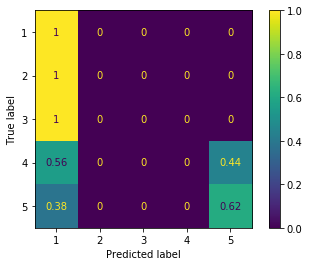

In [21]:
plot_confusion_matrix(grid.best_estimator_, valid_df.prep.values, valid_df.mark.values, normalize="true")